# Load Libraries

In [448]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sklearn

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc

# Please pass your API key here
# pc.settings.set_subscription_key('********************')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm.notebook import tqdm as tqdm
tqdm.pandas()

# Read Data

In [449]:
crop_yield_data = pd.read_csv("Crop_Yield_Data_challenge_2.csv", parse_dates=['Date of Harvest'])
crop_yield_data.columns = ['district', 'latitude', 'longitude', 'season', 'intensity', 'date_of_harvest', 'field_size', 'rice_yield']
crop_yield_data.head()

,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield
0,Chau_Phu,10.510542,105.248554,SA,T,2022-07-15,3.40,5500
1,Chau_Phu,10.509150,105.265098,SA,T,2022-07-15,2.43,6000
2,Chau_Phu,10.467721,105.192464,SA,D,2022-07-15,1.95,6400
3,Chau_Phu,10.494453,105.241281,SA,T,2022-07-15,4.30,6000
4,Chau_Phu,10.535058,105.252744,SA,D,2022-07-14,3.30,6400


In [450]:
crop_yield_data[crop_yield_data.duplicated(subset=['latitude', 'longitude'], keep=False)].sort_values(['latitude', 'longitude'])

,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield
449,Thoai_Son,10.195117,105.200047,SA,T,2022-07-20,3.20,5600
531,Thoai_Son,10.195117,105.200047,WS,T,2022-05-04,3.20,7200
445,Thoai_Son,10.208515,105.202809,SA,T,2022-07-20,2.67,6400
527,Thoai_Son,10.208515,105.202809,WS,T,2022-05-04,2.67,7200
451,Thoai_Son,10.227394,105.164987,SA,T,2022-07-20,3.00,5600
...,...,...,...,...,...,...,...,...
119,Chau_Phu,10.636733,105.155635,WS,T,2022-10-04,3.20,8000
28,Chau_Phu,10.649258,105.142121,SA,D,2022-05-08,1.75,6000
120,Chau_Phu,10.649258,105.142121,WS,D,2022-10-04,1.75,8000
29,Chau_Phu,10.663484,105.168203,SA,D,2022-05-08,3.00,6500


In [451]:
sub_sample = pd.read_csv("Challenge_2_submission_template.csv", parse_dates=['Date of Harvest'])
sub_sample.columns = ['id', 'district', 'latitude', 'longitude', 'season', 'intensity', 'date_of_harvest', 'field_size', 'rice_yield']
sub_sample.head()

,id,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield
0,1,Chau_Phu,10.542192,105.187920,WS,T,2022-10-04,1.40,NaN
1,2,Chau_Thanh,10.400189,105.331053,SA,T,2022-07-15,1.32,NaN
2,3,Chau_Phu,10.505489,105.203926,SA,D,2022-07-14,1.40,NaN
3,4,Chau_Phu,10.523520,105.138274,WS,D,2022-10-04,1.80,NaN
4,5,Thoai_Son,10.294660,105.248528,SA,T,2022-07-20,2.20,NaN


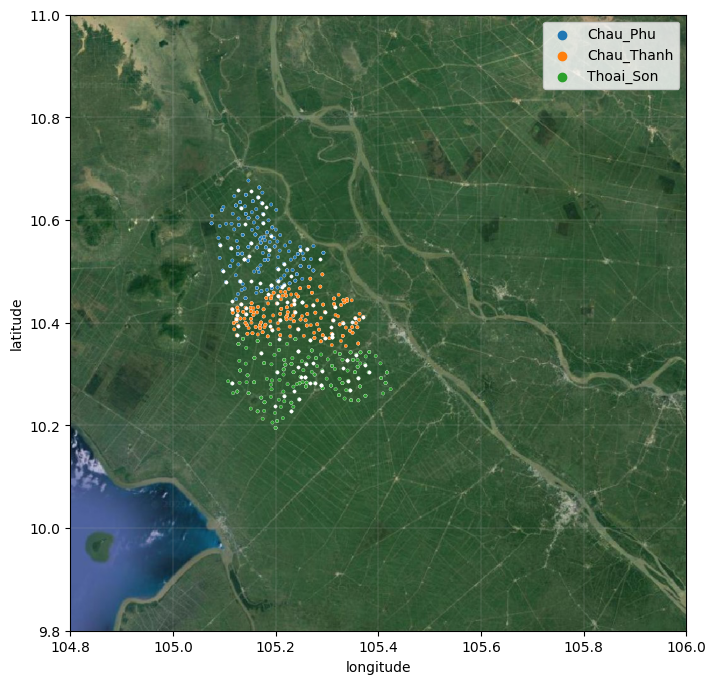

In [452]:
sns.scatterplot(data=crop_yield_data, x='longitude', y='latitude', hue='district', s=6)
sns.scatterplot(data=sub_sample, x='longitude', y='latitude', color='white', s=6)


fig = plt.gcf()
ax  = plt.gca()

fig.set_size_inches(8, 8)

ax.set_aspect('equal')
ax.patch.set_alpha(0)
plt.grid(lw=0.15)
plt.legend()
# legend.legendHandles[0]._sizes = [40]
# legend.legendHandles[1]._sizes = [40]
# legend.set_alpha(0)

plt.xlim(104.8, 106)
plt.ylim(9.8, 11)

# [0.06, 0, 0.95, 0.95]

newax = fig.add_axes(ax.get_position(), anchor='SW', zorder=-15)
# newax.set_position(ax.get_position())
newax.imshow(plt.imread('../Full Region no labels.jpg'), aspect='auto')
newax.axis('off')
# ax.set_xlim(105.3338 - 10**-2/2, 105.3338+ 10**-2/2)
# ax.set_ylim(10.4391  - 10**-2/2, 10.4391 + 10**-2/2)
# newax.set_xlim(105.3338 - 10**-2/2, 105.3338+ 10**-2/2)
# newax.set_ylim(10.4391  - 10**-2/2, 10.4391 + 10**-2/2)
plt.grid(False)

# Process Data

## Constant Features

<AxesSubplot:>

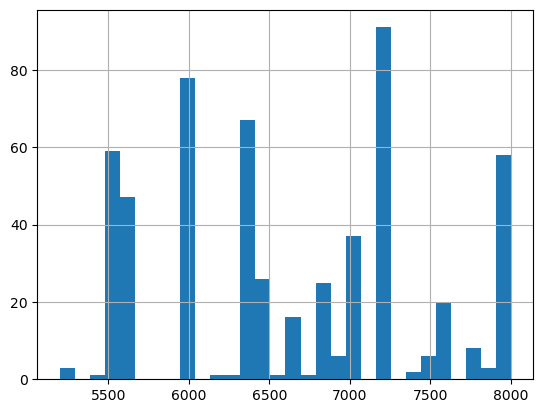

In [453]:
crop_yield_data['rice_yield'].hist(bins=30)

<AxesSubplot:>

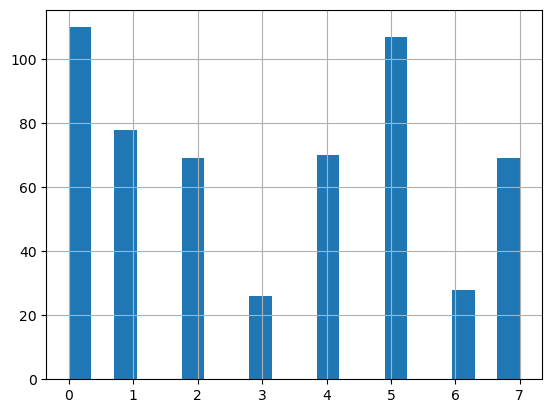

In [454]:
crop_yield_data['target_class'] = pd.qcut(crop_yield_data['rice_yield'], q=8, labels=False)
crop_yield_data['target_class'].hist(bins=20)

In [455]:
crop_yield_data.head(2)

,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield,target_class
0,Chau_Phu,10.510542,105.248554,SA,T,2022-07-15,3.40,5500,0
1,Chau_Phu,10.509150,105.265098,SA,T,2022-07-15,2.43,6000,1


In [456]:
train_const_data = pd.get_dummies(crop_yield_data.drop(['district'], axis=1), drop_first=True).drop(['latitude', 'longitude'], axis=1)
sub_const_data   = pd.get_dummies(sub_sample.drop(['district', 'rice_yield', 'id'], axis=1), drop_first=True).drop(['latitude', 'longitude'], axis=1)
display(train_const_data.head(2), sub_const_data.head(2))

,date_of_harvest,field_size,rice_yield,target_class,season_WS,intensity_T
0,2022-07-15,3.40,5500,0,0,1
1,2022-07-15,2.43,6000,1,0,1


,date_of_harvest,field_size,season_WS,intensity_T
0,2022-10-04,1.40,1,1
1,2022-07-15,1.32,0,1


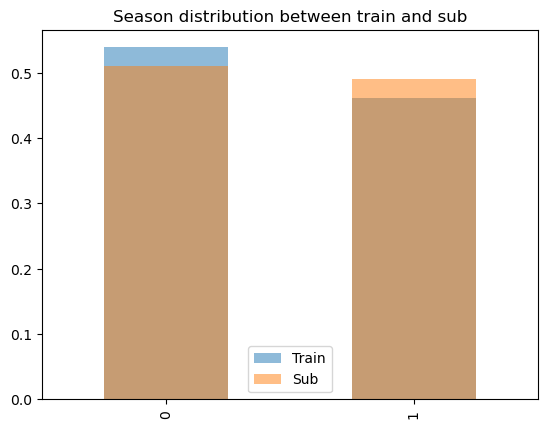

In [457]:
train_const_data.season_WS.value_counts(normalize=True).plot.bar(alpha=0.5, label='Train')
sub_const_data.season_WS.value_counts(normalize=True).plot.bar(alpha=0.5, color='C1', label='Sub')
plt.title('Season distribution between train and sub')
plt.legend();

In [458]:
train_const_data['start_of_harvest']     = train_const_data.date_of_harvest - pd.to_timedelta('99d')
sub_const_data  ['start_of_harvest']     = sub_const_data.date_of_harvest -   pd.to_timedelta('99d')
train_const_data['dayofyear_of_harvest'] = train_const_data.date_of_harvest.dt.day_of_year
sub_const_data['dayofyear_of_harvest']   = sub_const_data.date_of_harvest.dt.day_of_year
display(train_const_data.head(2), sub_const_data.head(2))

,date_of_harvest,field_size,rice_yield,target_class,season_WS,intensity_T,start_of_harvest,dayofyear_of_harvest
0,2022-07-15,3.40,5500,0,0,1,2022-04-07,196
1,2022-07-15,2.43,6000,1,0,1,2022-04-07,196


,date_of_harvest,field_size,season_WS,intensity_T,start_of_harvest,dayofyear_of_harvest
0,2022-10-04,1.40,1,1,2022-06-27,277
1,2022-07-15,1.32,0,1,2022-04-07,196


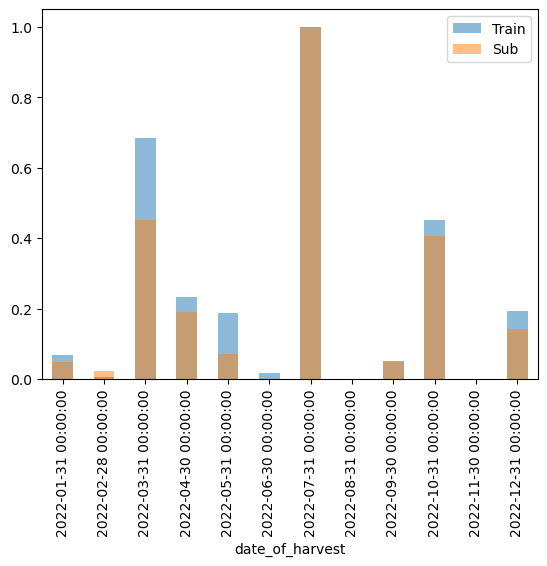

<AxesSubplot:>

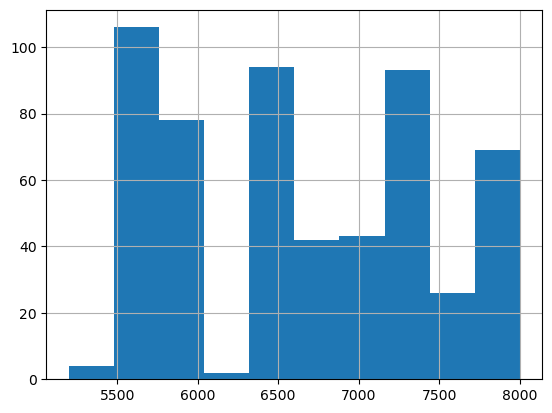

In [459]:
train_const_data.set_index('date_of_harvest').resample('m').count().apply(lambda x:x/x.max()).iloc[:, 0].plot.bar(alpha=0.5, label='Train')
sub_const_data.set_index('date_of_harvest').resample('m').count().apply(lambda x:x/x.max()).iloc[:, 0].plot.bar(alpha=0.5, color='C1', label='Sub')
plt.legend()
plt.show()
train_const_data.rice_yield.hist(bins=10)

In [460]:
# sns.kdeplot(data=train_const_data, x='date_of_harvest', y='rice_yield', hue='intensity_T', levels=8, fill=True, alpha=0.5)
# plt.title('Yield by date and by intensity')

In [461]:
# sns.heatmap(train_const_data.corr(), cmap='coolwarm', annot=True)

In [462]:
# sns.pairplot(train_const_data)

In [463]:
# sns.pairplot(sub_const_data)

## Time Series features

In [464]:
train_ts_data = pd.read_csv('train_data_level2.csv', index_col=['index', 'datetime'], parse_dates=True)
sub_ts_data   = pd.read_csv('sub_data_level2.csv'  , index_col=['index', 'datetime'], parse_dates=True)
# train_sent2_data = pd.read_csv('train_sentinel2_level2_fix.csv', index_col=['index', 'datetime'], parse_dates=True).drop('SCL', axis=1).replace(0, np.nan)
# sub_sent2_data = pd.read_csv('sub_sentinel2_level2.csv', index_col=['index', 'datetime'], parse_dates=True).drop('SCL', axis=1).replace(0, np.nan)

train_sent2_data = pd.read_pickle('../level2_sent2_train.df')
sub_sent2_data   = pd.read_pickle('../level2_sent2_sub.df'  )

display(train_ts_data.head(2), train_sent2_data.head(2), sub_sent2_data.head(2))

vh        vv       rvi
index datetime                                                
0     2021-09-05 22:45:35.619475  0.006411  0.036697  0.229400
      2021-09-11 22:46:08.311308  0.019033  0.295205  0.059627

red                                      \
                                  mean  median percentile_20 percentile_80   
  time                                                                       
0 2022-02-19 03:17:49.024  1649.775391  1406.5        1251.0        2036.0   
  2022-02-24 03:17:31.024          NaN     NaN           NaN           NaN   

                                             green                        \
                                  std         mean  median percentile_20   
  time                                                                     
0 2022-02-19 03:17:49.024  543.111408  1933.546509  1693.0        1556.0   
  2022-02-24 03:17:31.024         NaN          NaN     NaN           NaN   

                                                    ...      rededge          \
                          percentile_80        std  ...         mean  median   
  time                                              ...                        
0 2022-02-19 03:17:49.024   2336.399902  538.90375  ...  2205.781982  1990.5   
  2022-02-24 03:17:31.024           NaN        NaN  ...          NaN     NaN   

                                                                   \
                          percentile_20 percentile_80         std   
  time                                                              
0 2022-02-19 03:17:49.024        1798.0   2595.600098  581.085265   
  2022-02-24 03:17:31.024           NaN           NaN         NaN   

                                swir16                                      \
                                  mean  median percentile_20 percentile_80   
  time                                                                       
0 2022-02-19 03:17:49.024  3068.577881  2948.0   2656.399902   3432.600098   
  2022-02-24 03:17:31.024          NaN     NaN           NaN           NaN   

                                       
                                  std  
  time                                 
0 2022-02-19 03:17:49.024  605.145364  
  2022-02-24 03:17:31.024         NaN  

[2 rows x 30 columns]

red                                        green  \
                          mean median percentile_20 percentile_80 std  mean   
  time                                                                        
0 2021-11-11 03:19:49.024  NaN    NaN           NaN           NaN NaN   NaN   
  2021-11-16 03:20:11.024  NaN    NaN           NaN           NaN NaN   NaN   

                                                                  ... rededge  \
                          median percentile_20 percentile_80 std  ...    mean   
  time                                                            ...           
0 2021-11-11 03:19:49.024    NaN           NaN           NaN NaN  ...     NaN   
  2021-11-16 03:20:11.024    NaN           NaN           NaN NaN  ...     NaN   

                                                                 swir16  \
                          median percentile_20 percentile_80 std   mean   
  time                                                                    
0 2021-11-11 03:19:49.024    NaN           NaN           NaN NaN    NaN   
  2021-11-16 03:20:11.024    NaN           NaN           NaN NaN    NaN   

                                                                  
                          median percentile_20 percentile_80 std  
  time                                                            
0 2021-11-11 03:19:49.024    NaN           NaN           NaN NaN  
  2021-11-16 03:20:11.024    NaN           NaN           NaN NaN  

[2 rows x 30 columns]

In [465]:
# Add ratio vv/vh
# train_ts_data = train_ts_data.assign(ratio=lambda x:x['vv']/x['vh']/10)
# sub_ts_data = sub_ts_data.assign(ratio=lambda x:x['vv']/x['vh']/10)
# display(train_ts_data.head(2), sub_ts_data.head(2))

# Add Indices to Sentinel 2
def AddBands(sent2_data, multiindex):
    if multiindex:
        sent2_data = sent2_data.stack()
    sent2_data = sent2_data.assign(ndvi =lambda x:(x.nir-x.red)/(x.nir+x.red),
                                           ndwi =lambda x:(x.nir-x.swir16)/(x.nir+x.swir16),
                                           ndbsi=lambda x:((x.nir+x.blue)-(x.red+x.swir16))/((x.nir+x.blue)+(x.red+x.swir16)),
                                           ndre =lambda x:(x.nir-x.rededge)/(x.nir+x.rededge))
    if multiindex:
        sent2_data = sent2_data.unstack()
    return sent2_data

train_sent2_data = AddBands(train_sent2_data, True)
sub_sent2_data = AddBands(sub_sent2_data, True)
display(train_sent2_data.head(2), sub_sent2_data.head(2))

red                                      \
                                  mean  median percentile_20 percentile_80   
  time                                                                       
0 2022-02-19 03:17:49.024  1649.775391  1406.5        1251.0        2036.0   
  2022-03-01 03:16:49.024  1348.125000  1311.0        1268.0        1360.0   

                                             green                        \
                                  std         mean  median percentile_20   
  time                                                                     
0 2022-02-19 03:17:49.024  543.111408  1933.546509  1693.0        1556.0   
  2022-03-01 03:16:49.024  159.966914  1601.489746  1578.0        1527.0   

                                                    ...     ndbsi            \
                          percentile_80        std  ...      mean    median   
  time                                              ...                       
0 2022-02-19 03:17:49.024   2336.399902  538.90375  ...  0.204254  0.233633   
  2022-03-01 03:16:49.024   1641.000000  125.25244  ...  0.228254  0.239823   

                                                                     ndre  \
                          percentile_20 percentile_80       std      mean   
  time                                                                      
0 2022-02-19 03:17:49.024      0.214008      0.205596  0.112829  0.419817   
  2022-03-01 03:16:49.024      0.220788      0.251032  0.348283  0.417205   

                                                                           
                             median percentile_20 percentile_80       std  
  time                                                                     
0 2022-02-19 03:17:49.024  0.471350      0.445164       0.40872  0.209851  
  2022-03-01 03:16:49.024  0.428571      0.410419       0.43604  0.608392  

[2 rows x 50 columns]

red                                     \
                                 mean median percentile_20 percentile_80   
  time                                                                     
0 2021-11-21 03:20:29.024  758.519165  630.0    512.799988    942.200012   
  2021-11-26 03:20:51.024  587.637634  542.0    427.200012    686.799988   

                                             green                       \
                                  std         mean median percentile_20   
  time                                                                    
0 2021-11-21 03:20:29.024  397.815948  1068.134399  961.0    812.799988   
  2021-11-26 03:20:51.024  295.000420   805.806946  756.0    639.000000   

                                                     ...     ndbsi            \
                          percentile_80         std  ...      mean    median   
  time                                               ...                       
0 2021-11-21 03:20:29.024   1264.400024  398.775339  ...  0.243468  0.264246   
  2021-11-26 03:20:51.024    926.799988  300.779221  ...  0.206413  0.210310   

                                                                     ndre  \
                          percentile_20 percentile_80       std      mean   
  time                                                                      
0 2021-11-21 03:20:29.024      0.241890      0.251388  0.202453  0.436857   
  2021-11-26 03:20:51.024      0.198688      0.219185  0.229133  0.407671   

                                                                           
                             median percentile_20 percentile_80       std  
  time                                                                     
0 2021-11-21 03:20:29.024  0.469328      0.451329       0.44143  0.370255  
  2021-11-26 03:20:51.024  0.417609      0.420841       0.40945  0.341555  

[2 rows x 50 columns]

In [466]:
multicols_names = train_sent2_data.columns.map('_'.join)
train_sent2_data.columns = multicols_names
sub_sent2_data.columns   = multicols_names

train_sent2_data.head(2)

red_mean  red_median  red_percentile_20  \
  time                                                                  
0 2022-02-19 03:17:49.024  1649.775391      1406.5             1251.0   
  2022-03-01 03:16:49.024  1348.125000      1311.0             1268.0   

                           red_percentile_80     red_std   green_mean  \
  time                                                                  
0 2022-02-19 03:17:49.024             2036.0  543.111408  1933.546509   
  2022-03-01 03:16:49.024             1360.0  159.966914  1601.489746   

                           green_median  green_percentile_20  \
  time                                                         
0 2022-02-19 03:17:49.024        1693.0               1556.0   
  2022-03-01 03:16:49.024        1578.0               1527.0   

                           green_percentile_80  green_std  ...  ndbsi_mean  \
  time                                                     ...               
0 2022-02-19 03:17:49.024          2336.399902  538.90375  ...    0.204254   
  2022-03-01 03:16:49.024          1641.000000  125.25244  ...    0.228254   

                           ndbsi_median  ndbsi_percentile_20  \
  time                                                         
0 2022-02-19 03:17:49.024      0.233633             0.214008   
  2022-03-01 03:16:49.024      0.239823             0.220788   

                           ndbsi_percentile_80  ndbsi_std  ndre_mean  \
  time                                                                 
0 2022-02-19 03:17:49.024             0.205596   0.112829   0.419817   
  2022-03-01 03:16:49.024             0.251032   0.348283   0.417205   

                           ndre_median  ndre_percentile_20  \
  time                                                       
0 2022-02-19 03:17:49.024     0.471350            0.445164   
  2022-03-01 03:16:49.024     0.428571            0.410419   

                           ndre_percentile_80  ndre_std  
  time                                                   
0 2022-02-19 03:17:49.024             0.40872  0.209851  
  2022-03-01 03:16:49.024             0.43604  0.608392  

[2 rows x 50 columns]

In [467]:
train_sent2_data = train_sent2_data.filter(regex=r'mean|percentile_(80|20)')
sub_sent2_data = sub_sent2_data.filter(regex=r'mean|percentile_(80|20)')

In [468]:
# Drop a column
# train_sent2_data = train_sent2_data.drop(['red', 'green', 'blue'], axis=1)
# sub_sent2_data = sub_sent2_data.drop(['red', 'green', 'blue'], axis=1)

# display(train_sent2_data.head(2), sub_sent2_data.head(2))

In [469]:
def is_outlier(series, factor=1, print_range=False):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR*factor
    upper_bound = Q3 + 1.5 * IQR*factor
    if print_range:
        print(upper_bound, lower_bound)
    boolean_filter = (series < lower_bound) | (series > upper_bound)
    return pd.Series(np.where(boolean_filter,
                                       np.nan,
                                       series),
                              index=series.index)

In [470]:
# Transformación de variables sentinel 1
train_ts_data[['vv', 'vh']] = train_ts_data[['vv', 'vh']].apply(lambda x:np.log10(x))
train_ts_data['rvi'] = train_ts_data['rvi'].apply(lambda x:x**0.5)
sub_ts_data[['vv', 'vh']] = sub_ts_data[['vv', 'vh']].apply(lambda x:np.log10(x))
sub_ts_data['rvi'] = sub_ts_data['rvi'].apply(lambda x:x**0.5)

In [471]:
columns_to_transform = 'red,green,blue,nir,rededge,swir16'.split(',')
train_sent2_data.loc[:, train_sent2_data.columns.str.contains('|'.join(columns_to_transform))] = train_sent2_data.loc[:, train_sent2_data.columns.str.contains('|'.join(columns_to_transform))].apply(lambda x: np.log10(x))
sub_sent2_data.loc[:, sub_sent2_data.columns.str.contains('|'.join(columns_to_transform))] = sub_sent2_data.loc[:, sub_sent2_data.columns.str.contains('|'.join(columns_to_transform))].apply(lambda x: np.log10(x))

In [472]:
train_sent2_data

red_mean  red_percentile_20  red_percentile_80  \
    time                                                                      
0   2022-02-19 03:17:49.024  3.217425           3.097257           3.308778   
    2022-03-01 03:16:49.024  3.129730           3.103119           3.133539   
    2022-03-06 03:16:21.024  3.268315           3.205475           3.327155   
    2022-03-11 03:15:39.024  3.187317           3.161967           3.192567   
    2022-03-21 03:15:39.024  3.397849           3.376869           3.421933   
...                               ...                ...                ...   
556 2021-12-31 03:21:29.024  2.856986           2.670246           2.995635   
    2022-01-05 03:21:31.024  2.933787           2.693199           3.048131   
    2022-01-10 03:21:09.024  2.705099           2.437751           2.837588   
    2022-01-20 03:20:39.024  2.604218           2.318063           2.691081   
    2022-01-30 03:19:49.024  3.299926           3.240998           3.337659   

                             green_mean  green_percentile_20  \
    time                                                       
0   2022-02-19 03:17:49.024    3.286355             3.192010   
    2022-03-01 03:16:49.024    3.204524             3.183839   
    2022-03-06 03:16:21.024    3.329770             3.277380   
    2022-03-11 03:15:39.024    3.260706             3.242044   
    2022-03-21 03:15:39.024    3.432093             3.412293   
...                                 ...                  ...   
556 2021-12-31 03:21:29.024    2.910657             2.819544   
    2022-01-05 03:21:31.024    3.029235             2.874598   
    2022-01-10 03:21:09.024    2.876360             2.774517   
    2022-01-20 03:20:39.024    2.827334             2.722634   
    2022-01-30 03:19:49.024    3.382884             3.346353   

                             green_percentile_80  blue_mean  \
    time                                                      
0   2022-02-19 03:17:49.024             3.368547   3.241207   
    2022-03-01 03:16:49.024             3.215109   3.125995   
    2022-03-06 03:16:21.024             3.381296   3.270868   
    2022-03-11 03:15:39.024             3.271377   3.172247   
    2022-03-21 03:15:39.024             3.456366   3.411866   
...                                          ...        ...   
556 2021-12-31 03:21:29.024             2.978637   2.766403   
    2022-01-05 03:21:31.024             3.116342   2.997943   
    2022-01-10 03:21:09.024             2.914872   2.703173   
    2022-01-20 03:20:39.024             2.865104   2.597896   
    2022-01-30 03:19:49.024             3.405517   3.378741   

                             blue_percentile_20  blue_percentile_80  nir_mean  \
    time                                                                        
0   2022-02-19 03:17:49.024            3.130977            3.325351  3.732230   
    2022-03-01 03:16:49.024            3.107210            3.130977  3.676832   
    2022-03-06 03:16:21.024            3.201397            3.334051  3.687434   
    2022-03-11 03:15:39.024            3.148294            3.179667  3.693663   
    2022-03-21 03:15:39.024            3.390228            3.437433  3.620996   
...                                         ...                 ...       ...   
556 2021-12-31 03:21:29.024            2.622214            2.862131  3.218495   
    2022-01-05 03:21:31.024            2.767453            3.115011  3.226352   
    2022-01-10 03:21:09.024            2.540329            2.763428  3.403899   
    2022-01-20 03:20:39.024            2.404834            2.627366  3.513203   
    2022-01-30 03:19:49.024            3.335658            3.402433  3.717992   

                             ...  ndvi_percentile_80  ndwi_mean  \
    time                     ...                                  
0   2022-02-19 03:17:49.024  ...            0.504623   0.275128   
    2022-03-01 03:16:49.024  ...            0.583078   0.314624   
    2022-03-06 03:16:21.02

In [473]:
# Transformación de variables sentinel 2
# train_sent2_data.loc[:, 'red,green,blue,nir,rededge,swir16'.split(',')] = train_sent2_data['red,green,blue,nir,rededge,swir16'.split(',')].apply(lambda x:np.log10(x))
# sub_sent2_data.loc[  :, 'red,green,blue,nir,rededge,swir16'.split(',')] = sub_sent2_data[  'red,green,blue,nir,rededge,swir16'.split(',')].apply(lambda x:np.log10(x))

In [474]:
# Check boxplot with different outliers filters
# train_ts_data.plot.box()
# sub_ts_data.plot.box()
# train_sent2_data.plot.box()
# sub_sent2_data.plot.box()

In [475]:
train_ts_data    = train_ts_data.apply(is_outlier, args=[10])
sub_ts_data      = sub_ts_data.apply(  is_outlier, args=[10])
train_sent2_data = train_sent2_data.apply(is_outlier, args=[10])
sub_sent2_data   = sub_sent2_data.apply(is_outlier, args=[10])

In [476]:
# Check boxplot after outlier filters
# train_ts_data.plot.box()
# sub_ts_data.plot.box()
# train_sent2_data.plot.box()
# sub_sent2_data.plot.box()

### Slicing time frame

In [477]:
train_ts_data.reset_index(level=1).groupby(level=0)\
.apply(lambda x: x.set_index('datetime').resample('1d').median())

vh        vv       rvi
index datetime                                
0     2021-09-05 -2.193083 -1.435365  0.478958
      2021-09-06       NaN       NaN       NaN
      2021-09-07       NaN       NaN       NaN
      2021-09-08       NaN       NaN       NaN
      2021-09-09       NaN       NaN       NaN
...                    ...       ...       ...
556   2022-12-20       NaN       NaN       NaN
      2022-12-21       NaN       NaN       NaN
      2022-12-22       NaN       NaN       NaN
      2022-12-23 -2.160165 -0.943620  0.234108
      2022-12-24 -2.162919 -1.291836  0.404201

[265132 rows x 3 columns]

In [478]:
train_ts_data = pd.concat([train_ts_data, train_sent2_data], axis=1)
sub_ts_data   = pd.concat([sub_ts_data   , sub_sent2_data] , axis=1)

In [479]:
train_ts_data    = train_ts_data.unstack(    level=0).resample('10d').mean().interpolate().bfill().ffill().stack(dropna=False).swaplevel().sort_index(level=0)
sub_ts_data      = sub_ts_data.unstack(      level=0).resample('10d').mean().interpolate().bfill().ffill().stack(dropna=False).swaplevel().sort_index(level=0)

In [480]:
# Create slices to keep only 100 days prior to harvest for each coordinate

harvest_slices = []
for idx in range(len(train_ts_data.index.levels[0])):
    harvest_slices.append((idx, slice(train_const_data.loc[idx, 'start_of_harvest'], train_const_data.loc[idx, 'date_of_harvest'])))
data_slices = []
for hs in harvest_slices:
    data_slices.append(train_ts_data.loc[hs, :])
    
# Concatenate slices
train_ts_data = pd.concat(data_slices)

# Sub
harvest_slices = []
for idx in range(len(sub_ts_data.index.levels[0])):
    harvest_slices.append((idx, slice(sub_const_data.loc[idx, 'start_of_harvest'], sub_const_data.loc[idx, 'date_of_harvest'])))
data_slices = []
for hs in harvest_slices:
    data_slices.append(sub_ts_data.loc[hs, :])
    
# Concatenate slices
sub_ts_data = pd.concat(data_slices)

305


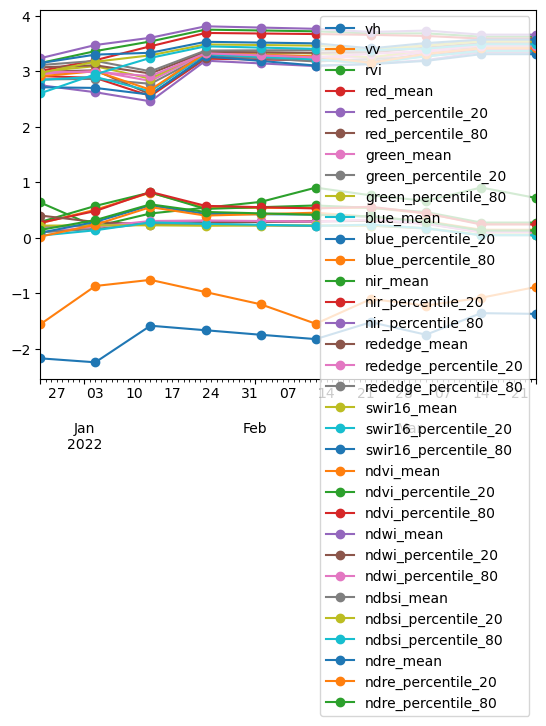

92


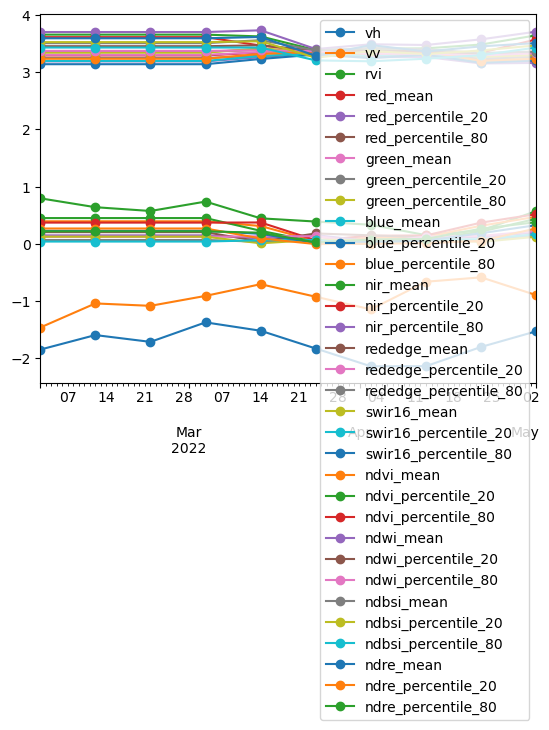

In [481]:
# Visualize data for one random sample
rand = np.random.randint(0, 556)
print(rand)
train_ts_data.loc[rand].plot(marker='o')
# [plt.axvline(train_const_data.loc[rand, i], c='k', ls='--', alpha=0.5) for i in ['start_of_harvest', 'date_of_harvest']];
plt.show();

# Visualize data for one random sample
rand = np.random.randint(0, 99)
print(rand)
sub_ts_data.loc[49].plot(marker='o')
# [plt.axvline(sub_const_data.loc[rand, i], c='k', ls='--', alpha=0.5) for i in ['start_of_harvest', 'date_of_harvest']];
plt.show();

### Detect TS Anomalies

In [482]:
# import torch
import torch.nn as nn

# Define a simple RNN model with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Feed input sequence through the LSTM
        out, _ = self.rnn(x, (h0, c0))

        # Pass the output sequence through a fully connected layer
        out = self.fc(out)

        return out

# Define a loss function that penalizes large deviations from the predicted values
class AnomalyDetectionLoss(nn.Module):
    def __init__(self, threshold):
        super(AnomalyDetectionLoss, self).__init__()
        self.threshold = threshold

    def forward(self, y_pred, y_true):
        errors = torch.abs(y_pred - y_true)
        mask = errors > self.threshold
        loss = torch.mean(torch.where(mask, errors, torch.zeros_like(errors)))
        return loss

# Define a training function that uses an optimizer to minimize the loss
def train_model(model, train_loader, optimizer, loss_fn, num_epochs):
    for epoch in range(num_epochs):
        for i, (inputs) in enumerate(train_loader):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, inputs)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()), end='\r')

# Define a function to detect anomalies in a time series
def detect_anomalies(model, data, threshold):
    inputs = torch.Tensor(data)
    outputs = model(inputs)
    print(inputs.shape, outputs.shape)
    errors = torch.abs(outputs - inputs)
    mask = errors > threshold
    return mask.squeeze().detach().cpu().numpy()

# # Example usage:
# threshold = 3
# data = torch.Tensor(np.vstack([train_ts_data.values.reshape(557, 100, -1), sub_ts_data.values.reshape(100, 100, -1)])).to('cuda')
# model = RNN(input_size=data.shape[2], hidden_size=10, output_size=data.shape[2]).to('cuda')
# optimizer = torch.optim.Adam(model.parameters(), lr=10**-4)
# loss_fn = AnomalyDetectionLoss(threshold=threshold)
# train_loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)
# train_model(model, train_loader, optimizer, loss_fn, num_epochs=20)

In [483]:
# anomaly_mask_train = detect_anomalies(model, data[:557], threshold=threshold*0.35)
# anomaly_mask_sub   = detect_anomalies(model, data[557:], threshold=threshold*0.35)

In [484]:
# anomaly_mask_train_df = pd.DataFrame(anomaly_mask_train.reshape(train_ts_data.shape), index=train_ts_data.index, columns=train_ts_data.columns)
# anomaly_mask_sub_df   = pd.DataFrame(anomaly_mask_sub.reshape(sub_ts_data.shape)  , index=sub_ts_data.index  , columns=sub_ts_data.columns)

In [485]:
# # Join red, blue, green masks, and ndbi, etc, masks
# anomaly_mask_train_df[anomaly_mask_train_df.columns[3:8]] = anomaly_mask_train_df.iloc[:, 3:8].apply(np.logical_or.reduce, axis=1).to_frame().reindex(columns=anomaly_mask_train_df.columns[3:8])
# anomaly_mask_train_df[anomaly_mask_train_df.columns[9:]]  = anomaly_mask_train_df.iloc[:, 9: ].apply(np.logical_or.reduce, axis=1).to_frame().reindex(columns=anomaly_mask_train_df.columns[9:])
# anomaly_mask_train_df = anomaly_mask_train_df.ffill(axis=1)

# anomaly_mask_sub_df[anomaly_mask_sub_df.columns[3:8]] = anomaly_mask_sub_df.iloc[:, 3:8].apply(np.logical_or.reduce, axis=1).to_frame().reindex(columns=anomaly_mask_sub_df.columns[3:8])
# anomaly_mask_sub_df[anomaly_mask_sub_df.columns[9:]]  = anomaly_mask_sub_df.iloc[:, 9: ].apply(np.logical_or.reduce, axis=1).to_frame().reindex(columns=anomaly_mask_sub_df.columns[9:])
# anomaly_mask_sub_df = anomaly_mask_sub_df.ffill(axis=1)

In [486]:
# iterator = iter(range(0, 50))

In [487]:
# n = next(iterator)
# print(n)
# # n = 18
# # print(pd.DataFrame(anomaly_mask).stack().xs(n))
# for f in range(13):
#     plt.scatter(y=train_ts_data.iloc[:, f].xs(n).values, x=train_ts_data.iloc[:, f].xs(n).index, color=['gold' if x else 'blue' for x in anomaly_mask_train_df.xs(n).iloc[:, f]], zorder=100)
#     train_ts_data.iloc[:, f].xs(n).plot()
#     plt.title(train_ts_data.iloc[:, f].name)
#     plt.show();

In [488]:
# train_ts_data = train_ts_data.groupby(pd.Grouper(level=0)).apply(lambda x:x.rolling(3).median().bfill())
# sub_ts_data   = sub_ts_data.groupby(pd.Grouper(level=0)).apply(lambda x:x.rolling(3).median().bfill())

In [489]:
# # Fix and then fill nas
# train_ts_data = train_ts_data.groupby(pd.Grouper(level=0)).apply(lambda x:x.interpolate(limit_area='inside').ffill().bfill().fillna(0).rolling(3).median().bfill())
# sub_ts_data   = sub_ts_data.groupby(  pd.Grouper(level=0)).apply(lambda x:x.interpolate(limit_area='inside').ffill().bfill().fillna(0).rolling(3).median().bfill())

In [490]:
# n = next(iterator)
# print(n)
# n = 1
# # print(pd.DataFrame(anomaly_mask).stack().xs(n))
# for f in range(13):
#     plt.scatter(y=train_ts_data.iloc[:, f].xs(n).values, x=train_ts_data.iloc[:, f].xs(n).index, color=['gold' if x else 'blue' for x in anomaly_mask_train_df.xs(n).iloc[:, f]], zorder=100)
#     train_ts_data.iloc[:, f].xs(n).plot()
#     plt.title(train_ts_data.iloc[:, f].name)
#     plt.show();

### Check

In [491]:
# Check that all time_series are the same length
display(train_ts_data.groupby(level=0).count().iloc[:, 0].describe(),
        sub_ts_data.groupby(level=0).count().iloc[:, 0].describe())

count    557.0
mean      10.0
std        0.0
min       10.0
25%       10.0
50%       10.0
75%       10.0
max       10.0
Name: vh, dtype: float64

count    100.0
mean      10.0
std        0.0
min       10.0
25%       10.0
50%       10.0
75%       10.0
max       10.0
Name: vh, dtype: float64

In [492]:
assert 0 == train_ts_data.groupby(level=0).count().iloc[:, 0].describe()['std']
time_series_length = int(train_ts_data.groupby(level=0).count().iloc[:, 0].describe()['max'])

In [493]:
display(train_ts_data.isna().sum(),
        sub_ts_data.isna().sum())

vh                       0
vv                       0
rvi                      0
red_mean                 0
red_percentile_20        0
red_percentile_80        0
green_mean               0
green_percentile_20      0
green_percentile_80      0
blue_mean                0
blue_percentile_20       0
blue_percentile_80       0
nir_mean                 0
nir_percentile_20        0
nir_percentile_80        0
rededge_mean             0
rededge_percentile_20    0
rededge_percentile_80    0
swir16_mean              0
swir16_percentile_20     0
swir16_percentile_80     0
ndvi_mean                0
ndvi_percentile_20       0
ndvi_percentile_80       0
ndwi_mean                0
ndwi_percentile_20       0
ndwi_percentile_80       0
ndbsi_mean               0
ndbsi_percentile_20      0
ndbsi_percentile_80      0
ndre_mean                0
ndre_percentile_20       0
ndre_percentile_80       0
dtype: int64

vh                       0
vv                       0
rvi                      0
red_mean                 0
red_percentile_20        0
red_percentile_80        0
green_mean               0
green_percentile_20      0
green_percentile_80      0
blue_mean                0
blue_percentile_20       0
blue_percentile_80       0
nir_mean                 0
nir_percentile_20        0
nir_percentile_80        0
rededge_mean             0
rededge_percentile_20    0
rededge_percentile_80    0
swir16_mean              0
swir16_percentile_20     0
swir16_percentile_80     0
ndvi_mean                0
ndvi_percentile_20       0
ndvi_percentile_80       0
ndwi_mean                0
ndwi_percentile_20       0
ndwi_percentile_80       0
ndbsi_mean               0
ndbsi_percentile_20      0
ndbsi_percentile_80      0
ndre_mean                0
ndre_percentile_20       0
ndre_percentile_80       0
dtype: int64

## Extra constant features (time series descriptors)

In [494]:
def ordinal_distribution(data, dx=3, dy=1, taux=1, tauy=1, return_missing=False, tie_precision=None):
    '''
    Returns
    -------
     : tuple
       Tuple containing two arrays, one with the ordinal patterns occurring in data 
       and another with their corresponding probabilities.
       
    Attributes
    ---------
    data : array 
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`.
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    dy : int
         Embedding dimension (vertical axis); it must be 1 for time series 
         (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    return_missing: boolean
                    If `True`, it returns ordinal patterns not appearing in the 
                    symbolic sequence obtained from **data** are shown. If `False`,
                    these missing patterns (permutations) are omitted 
                    (default: `False`).
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
   
    '''
    def setdiff(a, b):
        '''
        Returns
        -------
        : array
            An array containing the elements in `a` that are not contained in `b`.
            
        Parameters
        ----------    
        a : tuples, lists or arrays
            Array in the format :math:`[[x_{100}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        b : tuples, lists or arrays
            Array in the format :math:`[[x_{100}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        '''

        a = np.asarray(a).astype('int64')
        b = np.asarray(b).astype('int64')

        _, ncols = a.shape

        dtype={'names':['f{}'.format(i) for i in range(ncols)],
            'formats':ncols * [a.dtype]}

        C = np.setdiff1d(a.view(dtype), b.view(dtype))
        C = C.view(a.dtype).reshape(-1, ncols)

        return(C)

    try:
        ny, nx = np.shape(data)
        data   = np.array(data)
    except:
        nx     = np.shape(data)[0]
        ny     = 1
        data   = np.array([data])

    if tie_precision is not None:
        data = np.round(data, tie_precision)

    partitions = np.concatenate(
        [
            [np.concatenate(data[j:j+dy*tauy:tauy,i:i+dx*taux:taux]) for i in range(nx-(dx-1)*taux)] 
            for j in range(ny-(dy-1)*tauy)
        ]
    )

    symbols = np.apply_along_axis(np.argsort, 1, partitions)
    symbols, symbols_count = np.unique(symbols, return_counts=True, axis=0)

    probabilities = symbols_count/len(partitions)

    if return_missing==False:
        return symbols, probabilities
    
    else:
        all_symbols   = list(map(list,list(itertools.permutations(np.arange(dx*dy)))))
        miss_symbols  = setdiff(all_symbols, symbols)
        symbols       = np.concatenate((symbols, miss_symbols))
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols.__len__())))
        
        return symbols, probabilities

In [495]:
def permutation_entropy(data, dx=3, dy=1, taux=1, tauy=1, base=2, normalized=True, probs=False, tie_precision=None):
    '''
    Returns Permutation Entropy
    Attributes:
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`
           or an ordinal probability distribution (such as the ones returned by :func:`ordpy.ordinal_distribution`).
    dx :   int
           Embedding dimension (horizontal axis) (default: 3).
    dy :   int
           Embedding dimension (vertical axis); it must be 1 for time series (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 2).
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value 
                (default: `True`). If `False`, it is not.
    probs : boolean
            If `True`, assumes **data** is an ordinal probability distribution. If 
            `False`, **data** is expected to be a one- or two-dimensional 
            array (default: `False`). 
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
    '''
    if not probs:
        _, probabilities = ordinal_distribution(data, dx, dy, taux, tauy, return_missing=False, tie_precision=tie_precision)
    else:
        probabilities = np.asarray(data)
        probabilities = probabilities[probabilities>0]

    if normalized==True and base in [2, '2']:        
        smax = np.log2(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log2(probabilities))
        return s/smax
         
    elif normalized==True and base=='e':        
        smax = np.log(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log(probabilities))
        return s/smax
    
    elif normalized==False and base in [2, '2']:
        return -np.sum(probabilities*np.log2(probabilities))
    else:
        return -np.sum(probabilities*np.log(probabilities))

In [496]:
def generate_stastical_features_fix(group):
    '''
    Returns a  list of statistical features such as min,max,range,mean,auto-correlation,permutation entropy for each of the features
    Attributes:
    dataframe - DataFrame consisting of VV,VH and VV/VH for a time period
    '''
    out = group.agg(['min', 'max', 'ptp', 'mean'])

    for i in range(1):
        out.loc[f'auto_corr_{i+1}', :] = group.apply(lambda x:sm.tsa.acf(x)[i+1])

    out.loc['permut_entropy', :] = group.apply(lambda x:permutation_entropy(x, dx=3, base=2, normalized=True))
        
    return out

In [497]:
descriptors_train = train_ts_data.groupby(level=0).progress_apply(lambda x:generate_stastical_features_fix(x))
descriptors_sub   = sub_ts_data.groupby  (level=0).progress_apply(lambda x:generate_stastical_features_fix(x))

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [498]:
multicols_names = descriptors_train.unstack().columns.map('_'.join)

descriptors_train = descriptors_train.unstack().droplevel(0, axis=1)
descriptors_train.columns = multicols_names
descriptors_sub   = descriptors_sub.unstack().droplevel(0, axis=1)
descriptors_sub.columns   = multicols_names

display(descriptors_train.head(2), descriptors_sub.head(2))

,vh_min,vh_max,vh_ptp,vh_mean,vh_auto_corr_1,vh_permut_entropy,vv_min,vv_max,vv_ptp,vv_mean,...,ndre_percentile_20_ptp,ndre_percentile_20_mean,ndre_percentile_20_auto_corr_1,ndre_percentile_20_permut_entropy,ndre_percentile_80_min,ndre_percentile_80_max,ndre_percentile_80_ptp,ndre_percentile_80_mean,ndre_percentile_80_auto_corr_1,ndre_percentile_80_permut_entropy
0,-2.210720,-1.461969,0.748750,-1.692046,0.221916,0.967132,-1.555942,-0.510398,1.045544,-1.036180,...,0.583551,0.253483,0.712692,0.410558,-0.065187,0.451973,0.517160,0.284200,0.693018,0.410558
1,-1.629923,-1.197299,0.432624,-1.386341,0.410761,0.833915,-0.902614,-0.500263,0.402350,-0.717893,...,0.409657,0.256173,0.722694,0.599156,0.076495,0.435193,0.358698,0.317785,0.569574,0.599156


,vh_min,vh_max,vh_ptp,vh_mean,vh_auto_corr_1,vh_permut_entropy,vv_min,vv_max,vv_ptp,vv_mean,...,ndre_percentile_20_ptp,ndre_percentile_20_mean,ndre_percentile_20_auto_corr_1,ndre_percentile_20_permut_entropy,ndre_percentile_80_min,ndre_percentile_80_max,ndre_percentile_80_ptp,ndre_percentile_80_mean,ndre_percentile_80_auto_corr_1,ndre_percentile_80_permut_entropy
0,-2.295727,-1.424546,0.871180,-1.824601,0.689531,0.700698,-1.703092,-0.809725,0.893367,-1.135143,...,0.000000,0.075488,0.900000,-0.000000,0.107565,0.107565,0.000000,0.107565,NaN,-0.000000
1,-2.202142,-1.503377,0.698765,-1.680386,0.248945,0.967132,-1.517171,-0.351118,1.166053,-1.073831,...,0.420528,0.295187,0.401309,0.737202,0.135828,0.459119,0.323291,0.334428,0.277207,0.870419


In [499]:
train_const_data = pd.concat([train_const_data, descriptors_train], axis=1).drop(['start_of_harvest', 'target_class', 'date_of_harvest'], axis=1)
sub_const_data   = pd.concat([sub_const_data  , descriptors_sub], axis=1).drop(['start_of_harvest', 'date_of_harvest'], axis=1)
train_const_data.head(2)

,field_size,rice_yield,season_WS,intensity_T,dayofyear_of_harvest,vh_min,vh_max,vh_ptp,vh_mean,vh_auto_corr_1,...,ndre_percentile_20_ptp,ndre_percentile_20_mean,ndre_percentile_20_auto_corr_1,ndre_percentile_20_permut_entropy,ndre_percentile_80_min,ndre_percentile_80_max,ndre_percentile_80_ptp,ndre_percentile_80_mean,ndre_percentile_80_auto_corr_1,ndre_percentile_80_permut_entropy
0,3.40,5500,0,1,196,-2.210720,-1.461969,0.748750,-1.692046,0.221916,...,0.583551,0.253483,0.712692,0.410558,-0.065187,0.451973,0.517160,0.284200,0.693018,0.410558
1,2.43,6000,0,1,196,-1.629923,-1.197299,0.432624,-1.386341,0.410761,...,0.409657,0.256173,0.722694,0.599156,0.076495,0.435193,0.358698,0.317785,0.569574,0.599156


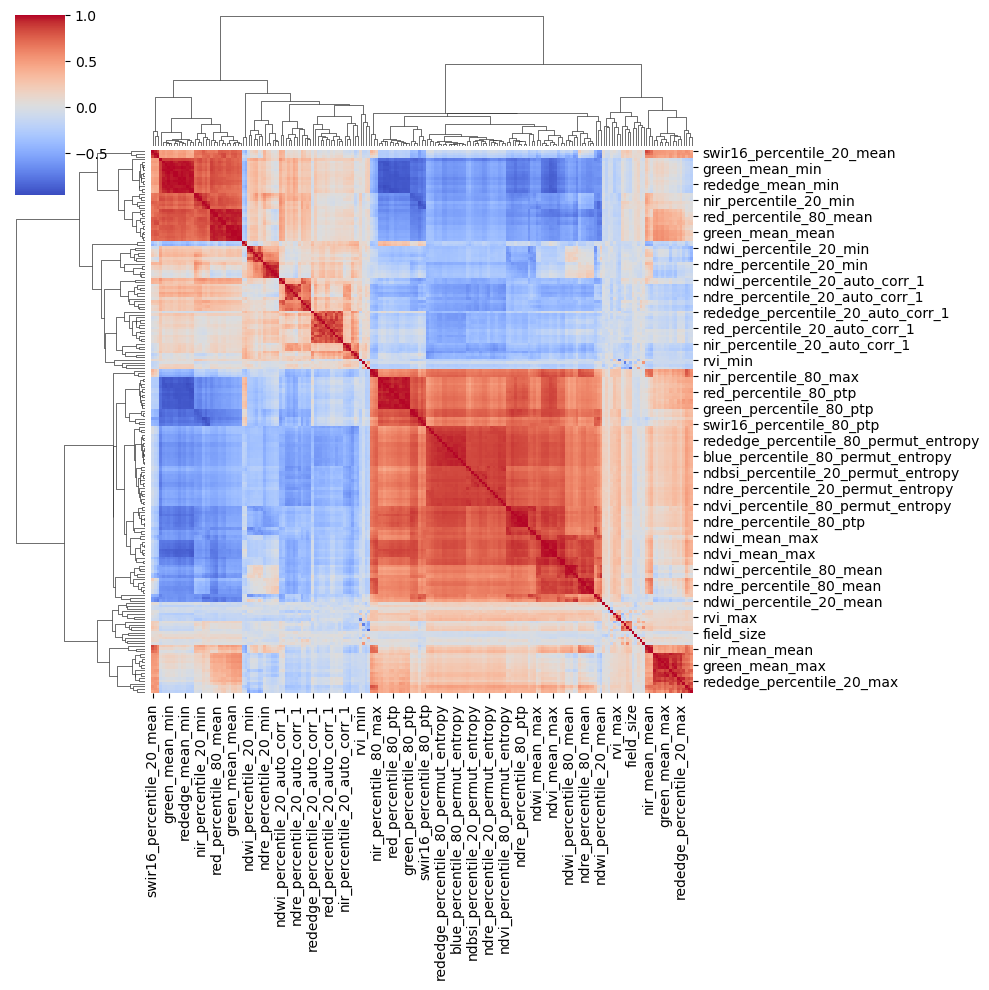

In [500]:
sns.clustermap(train_const_data.corr(), cmap='coolwarm')

In [501]:
train_const_data.isna().sum().sum()
sub_const_data.isna().sum().sum()

445

In [502]:
train_const_data = train_const_data.fillna(0)
sub_const_data   = sub_const_data.fillna(0)

In [503]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_regression
scaler = StandardScaler()
selector = SelectPercentile(f_regression, percentile=80)
selector.fit(scaler.fit_transform(train_const_data.drop('rice_yield', axis=1)), train_const_data.rice_yield)

SelectPercentile(percentile=80,
                 score_func=<function f_regression at 0x7f2397ad8280>)

<AxesSubplot:>

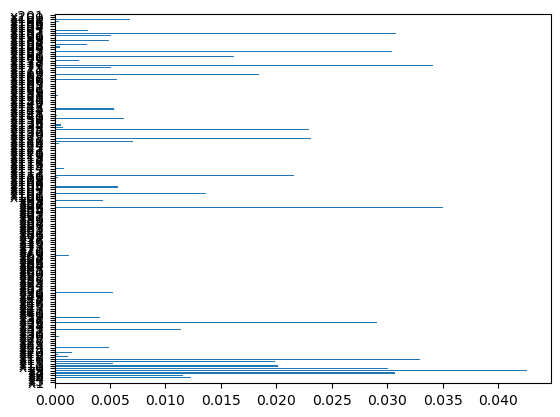

In [504]:
pd.Series(selector.pvalues_[selector.get_support()], index=selector.get_feature_names_out()).plot.barh()

In [505]:
train_const_data_pca = train_const_data.drop('rice_yield', axis=1)
sub_const_data_pca  = sub_const_data

# train_const_data_pca = pd.DataFrame(columns=train_const_data.drop('rice_yield', axis=1).columns[selector.get_support()], data=selector.transform(train_const_data.drop('rice_yield', axis=1)))
# sub_const_data_pca   = pd.DataFrame(columns=sub_const_data.columns[selector.get_support()], data=selector.transform(sub_const_data))

# Create Model

In [539]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

def TrainTorch(xtrain, ytrain, val_data=(None, None), n_epochs=800, model='convnet'):
    
    # Set boolean for validating
    validating = True
    if val_data==(None, None):
        validating = False

    # To CUDA
    xtrain = xtrain.to('cuda')
    ytrain = ytrain.to('cuda')
    if validating:
        val_data = (val_data[0].to('cuda'), val_data[1].to('cuda'))
    
    # From Torch Tensor to Torch Dataset
    dataset_train = TensorDataset(xtrain, ytrain)
    if validating:
        dataset_val   = TensorDataset(*list(val_data))
        
    class TST(nn.Module):
        def __init__(self, seq_len, n_features, n_encoder_layers=1, nhead=4, d_model=4, dim_feedforward=112):
            super(TST, self).__init__()
            self.seq_len = seq_len
            self.n_features = n_features

            self.embedding = nn.Linear(n_features, d_model)

            self.positional_encoding = nn.Parameter(torch.zeros(seq_len, 1, d_model))

            encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
            self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_encoder_layers)

            self.flatten = nn.Flatten()

        def forward(self, x):
            # x has shape (batch_size, seq_len, n_features)
            x = self.embedding(x)
            x = x.permute(1, 0, 2)

            # add positional encoding
            x = x + self.positional_encoding[:self.seq_len, :, :]

            # permute input for transformer layer

            # apply transformer encoder
            x = self.encoder(x)

            # permute output to original shape
            x = x.permute(1, 0, 2)

            # flatten output
            # x = self.flatten(x)
        
            return x
    # class ConvNet
    class ConvNet(nn.Module):
        def __init__(self, n_features, time_series_length):
            super(ConvNet, self).__init__()
            
            feature_map_depth1 = time_series_length*2
            
            self.transformer = TST(time_series_length, feature_map_depth1)
            
            self.globalconv = nn.Conv1d(n_features, feature_map_depth1, kernel_size=time_series_length, stride=1, padding=0)
            
            self.drop = nn.Dropout(0.25)
            self.relu = nn.ReLU()
            self.pool = nn.MaxPool1d(2)
            
            n_neurons = 64
            self.fc1 = nn.Linear(n_features, n_neurons)
            self.fc2 = nn.Linear(n_neurons, n_neurons)
            
            self.out = nn.Linear(n_neurons, 1)
            
        def forward(self, x, return_encoding=False):
            
            x = x.permute(0, 2, 1) # (Para conv1d tiene que entrar batch size, features, seq_length

            # Max Global Pooling         
            # x = x.permute(0, 2, 1)
            # x = self.transformer(x)
            # x = x.permute(0, 2, 1)
            # x = self.globalconv(x).squeeze(axis=2)
            # x = self.relu(x)
            x = torch.max(x, dim=2)[0]
            # x = torch.mean(x, dim=2)
            # x = torch.flatten(x, 1, 2)

            encoding = x
            x = self.fc1(x)
            x = self.relu(x)
            # x = self.drop(x)
            x = self.out(x)
            
            if return_encoding:
                return x, encoding
            else:
                return x
        
    class TransformerNet(nn.Module):
        def __init__(self, input_size, output_size, num_layers, hidden_size, hidden_size_transformer, num_heads, dropout):
            super(TransformerNet, self).__init__()
            self.embedding = nn.Linear(input_size, hidden_size)
            self.pos_embedding = nn.Embedding(time_series_length, hidden_size) # positional embedding
            self.transformer_encoder_layer = nn.TransformerEncoderLayer(hidden_size, num_heads, hidden_size_transformer, dropout, batch_first=True, norm_first=True)
            self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers)
            self.fc1 = nn.Linear(hidden_size, hidden_size*2)
            self.relu = nn.ReLU()
            self.out = nn.Linear(hidden_size*2, output_size)

        def forward(self, x, return_encoding=False):
            
            # x = x.permute(0, 2, 1)
            
            seq_length = x.shape[1]
            pos = torch.arange(seq_length).unsqueeze(0).repeat(x.shape[0], 1).to('cuda') # positional indices
            x = self.embedding(x) + self.pos_embedding(pos)
            x = self.transformer_encoder(x)
            x = F.avg_pool1d(x.permute(0, 2, 1), seq_length).squeeze() # global pooling
            encodings = x
            x = self.relu(self.fc1(x))
            x = self.out(x)
            if return_encoding: return x, encodings
            else: return x
        
    if model =='transformer':
        model = TransformerNet(input_size=n_features, output_size=1, num_layers=1, hidden_size=32, hidden_size_transformer=512, num_heads=4, dropout=0.1).to('cuda')
    elif model == 'convnet':
        model = ConvNet(n_features, time_series_length).to('cuda')
    else:
        raise Exception('Model has to be "convnet" or "transformer".')
    
    # Training parameters
    # optimizer = torch.optim.Adagrad(model.parameters(), lr=10**(-3.0), weight_decay=10**(-3), maximize=True)
    optimizer = torch.optim.AdamW(    model.parameters(), lr=10**(-4.0), weight_decay=10**(-1), maximize=False) # AdamW, 1 wd, 3.7 lr
    # optimizer = torch.optim.Adam(   model.parameters(), lr=10**(-4.0), weight_decay=10**(-2), maximize=False)
    # optimizer = torch.optim.SGD(    model.parameters(), lr=10**(-2.0), weight_decay=10**(-3), maximize=True)
    
    def smooth_r2_loss(y_pred, y_true, smooth_weight=0.3):
        ss_res = torch.sum(torch.square(y_true - y_pred))
        ss_tot = torch.sum(torch.square(y_true - torch.mean(y_true)))
        r2 = 1 - (ss_res + smooth_weight) / (ss_tot + smooth_weight)
        return r2
    criterion = nn.MSELoss()
    # criterion = smooth_r2_loss
    batch_size = 64
    epochs = n_epochs

    
    # Dataset to Dataloader
    dataloader_train = DataLoader(dataset_train    , batch_size=batch_size, shuffle=True)
    n_batches_train = (len(dataset_train) - 1)//batch_size+1
    if validating:
        dataloader_val   = DataLoader(dataset_val      , batch_size=batch_size, shuffle=True)
        n_batches_val   = (len(dataset_val  ) - 1)//batch_size+1
    else:
        n_batches_val = 1


    from sklearn.metrics import r2_score

    # Instantiate validation metrics
    stopping_counter = 0
    best_val_r2 = -np.inf

    # Training
    for epoch_n, epoch in tqdm(enumerate(range(epochs)), total=epochs):

        train_loss = 0.0
        model.train()
        for i, (x_, y_) in enumerate(dataloader_train):

            preds = model(x_)

            # Compute the loss
            loss = criterion(preds, y_)

            # Update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_r2 = 0.0
        if validating:

            for (x__, y__) in dataloader_val:

                # Forward Pass
                preds = model(x__)

                # Find the R2 score
                r2 = r2_score(y__.detach().cpu().numpy(), preds.detach().cpu().numpy())

                # Calculate R2 score
                val_r2 += r2

            patience = 20
            if val_r2 <= best_val_r2:
                stopping_counter += 1
                if stopping_counter == patience:
                    print(f'{stopping_counter} time(s) has the R2 score not improved. Finishing training...\n',
                        f'best epoch: {epoch_n - patience} training loss: {round(train_loss/n_batches_train, 4)} best val_R2: {np.round(best_val_r2/n_batches_val, 4)}'
                         )
                    break
            else:
                best_val_r2 = val_r2
                best_model = model
                stopping_counter = 0

        print(f'Training loss: {train_loss/n_batches_train:.4f}', 
        f'Validation R2 score: {val_r2/n_batches_val:.4f}',
        f'Stopping counter: {stopping_counter:02d}    ',
        end='\r')

    if validating:
        return best_model, best_val_r2/n_batches_val
    else:
        return model

## Prepare Data for Training

In [540]:
# Prepare data for training

# concat ts data with constant features
x = pd.concat([train_const_data_pca, train_ts_data.reset_index(level=1)], axis=1)\
.pipe(lambda x:x.set_index([x.index, 'level_1'])).drop(['season_WS'], axis=1)
xsub = pd.concat([sub_const_data_pca, sub_ts_data.reset_index(level=1)], axis=1)\
.pipe(lambda x:x.set_index([x.index, 'level_1'])).drop(['season_WS'], axis=1)

assert (x.columns == xsub.columns).all()

y = train_const_data.rice_yield.groupby(level=0).first().values.reshape(-1, 1)

# Reshape time series
n_samples = len(x)//time_series_length
time_series_length = time_series_length
n_features = x.shape[1]

# Convert to numpy array and reshape (n, length, features)
x    = x.values.reshape(n_samples, time_series_length, n_features)
xsub = xsub.values.reshape(  len(xsub.index.levels[0]), time_series_length, n_features)

display(x.shape, y.shape, xsub.shape)

(557, 10, 234)

(557, 1)

(100, 10, 234)

In [541]:
rand_state = np.random.randint(1, 373737)
rand_state = 190967 # buena correlacion con leaderboard
print(rand_state)

# Split test set
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(1, random_state=rand_state, test_size=0.2)
idx_fulltrain, idx_test = list(splitter.split(x, crop_yield_data.target_class))[0]
# Make splits
xfulltrain = x[idx_fulltrain]
yfulltrain = y[idx_fulltrain]
xtest      = x[idx_test]
ytest      = y[idx_test]
target_fulltrain = crop_yield_data.target_class.loc[idx_fulltrain]
target_test      = crop_yield_data.target_class.loc[idx_test]

# Use train set for cross-validation
from sklearn.model_selection import KFold, StratifiedKFold
def KFoldTraining(x_, y_, n_splits=5, is_sklearn=False, model_to_train=None, **kwargs):

    # K folds
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=rand_state+2)
    kfolds = list(kfold.split(x_, y_))
    
    # For each fold, scale data, train and append models
    models = []
    for i, fold in enumerate(kfolds):
        # Splitting
        train_idx, val_idx = fold[0], fold[1]
        xval      = x_[val_idx]
        yval      = y_[val_idx]
        xtrain    = x_[train_idx]
        ytrain    = y_[train_idx]
        
        # Add noise to ytrain
        # ytrain = ytrain + np.random.normal(0, 200, size=ytrain.shape)
        
        if not is_sklearn:
            # Scaling
            # Instantiate scalers
            from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler
            scaler_x = StandardScaler()
            scaler_y = StandardScaler()
            xtrain = scaler_x.fit_transform(xtrain.reshape(-1, xtrain.shape[2])).reshape(xtrain.shape)
            xval   = scaler_x.transform(xval.reshape(-1, xval.shape[2])).reshape(xval.shape)
            ytrain  = scaler_y.fit_transform(ytrain)
            yval    = scaler_y.transform(yval)
        
        
            # Cast to Tensors
            xtrain = torch.Tensor(xtrain)
            ytrain = torch.Tensor(ytrain)
            xval   = torch.Tensor(xval)
            yval   = torch.Tensor(yval)

            # Train and append model
            models.append(TrainTorch(xtrain, ytrain, (xval, yval), **kwargs))
        else:
            models.append(model_to_train.fit(xtrain, ytrain, eval_set=[(xval, yval)], early_stopping_rounds=10))
        
    return models

def FullDataTraining(x, y, **kwargs):
    # Scaling
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    x    = scaler_x.fit_transform(x.reshape(-1, x.shape[2])).reshape(x.shape)
    y    = scaler_y.fit_transform(y)

    # Cast to Tensors
    x    = torch.Tensor(x)
    y    = torch.Tensor(y)

    # Train and append model
    return TrainTorch(x, y, **kwargs)

190967


## Train on training set

In [542]:
models_losses = KFoldTraining(xfulltrain, yfulltrain, 5, model='convnet')

models = np.array(models_losses)[:, 0]
r2_scores = np.array(models_losses)[:, 1]

print('Average R2 on k-fold:' , r2_scores.mean())

  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 52 training loss: 0.2327 best val_R2: 0.6331


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19    
 best epoch: 24 training loss: 0.2806 best val_R2: 0.6362


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 98 training loss: 0.1874 best val_R2: 0.6794


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 46 training loss: 0.2557 best val_R2: 0.7039


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 31 training loss: 0.2696 best val_R2: 0.6229
Average R2 on k-fold: 0.6550887429516117


In [543]:
model = []
for i in np.linspace(30, 50, 5, dtype=int):
    model.append(FullDataTraining(xfulltrain, yfulltrain, n_epochs=i))
model = np.array(model)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [544]:
models_losses_transformer = KFoldTraining(xfulltrain, yfulltrain, 5, model='transformer')

models_tr = np.array(models_losses_transformer)[:, 0]
r2_scores = np.array(models_losses_transformer)[:, 1]
print('Average R2 on k-fold:' , r2_scores.mean())

  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 42 training loss: 0.2351 best val_R2: 0.6226


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19    
 best epoch: 93 training loss: 0.1982 best val_R2: 0.6692


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19    
 best epoch: 40 training loss: 0.2617 best val_R2: 0.6835


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19    
 best epoch: 29 training loss: 0.2767 best val_R2: 0.6895


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19    
 best epoch: 59 training loss: 0.238 best val_R2: 0.6558
Average R2 on k-fold: 0.6641123489968739


In [545]:
model_tr = []
for i in np.linspace(30, 40, 5, dtype=int):
    model_tr.append(FullDataTraining(xfulltrain, yfulltrain, n_epochs=i, model='transformer'))
model_tr = np.array(model)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

## Evaluate with test set

### Function and Scaling

In [565]:
def MakePredictions(model, xtest, is_sklearn=False):
    if type(model) is np.ndarray or type(model) is list:
        kfold_preds = []
        if is_sklearn:
            for m in model:
                kfold_preds.append(m.predict(xtest).squeeze())
        else:
            if type(xtest) != torch.Tensor:
                xtest = torch.Tensor(xtest)
            for m in model:
                kfold_preds.append(m(xtest.to('cuda')).cpu().detach().numpy().squeeze())
        preds = np.mean(np.array(kfold_preds), 0)
    else:
        try:
            preds = model.predict(xtest).squeeze()
        except:
            if type(xtest) != torch.Tensor:
                xtest = torch.Tensor(xtest)
                preds = model(xtest.to('cuda')).cpu().detach().numpy().squeeze()

    return preds

def EvaluationPlot(model, xtest, ytest, title='', plot=False, **kwargs):
                   
    preds = MakePredictions(model, xtest, **kwargs)
    
    # comparison preds, real
    from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as r2
    
    preds_df = pd.DataFrame(pd.concat([pd.Series(preds),
                                       pd.Series(ytest.squeeze())], axis=1))\
    .assign(error=lambda x:x[1] - x[0],
            mae=lambda x:mae(x[1], x[0]),
            mse=lambda x:np.sqrt(mse(x[1], x[0])),
            r2=lambda x:r2(x[1], x[0]))

    if plot:
        preds_df.pipe(lambda x:sns.regplot(data=x, x=x[1], y=x[0]))
        plt.plot(np.arange(preds_df[1].min(), preds_df[1].max()), np.arange(preds_df[1].min(), preds_df[1].max()), c='k', ls='-', alpha=0.35)
        plt.title(title)
        plt.show()
    print(title)
    display(preds_df.head(1))

In [547]:
# Scalers for test set
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler
scaler_x_fulltrain = StandardScaler()
scaler_y_fulltrain = StandardScaler()

xfulltrain = scaler_x_fulltrain.fit_transform(xfulltrain.reshape(-1, xfulltrain.shape[2])).reshape(xfulltrain.shape)
yfulltrain = scaler_y_fulltrain.fit_transform(yfulltrain)
xtest = scaler_x_fulltrain.transform(xtest.reshape(-1, xtest.shape[2])).reshape(xtest.shape)
ytest = scaler_y_fulltrain.transform(ytest)

scaler_x_sub = StandardScaler()
scaler_y_sub = StandardScaler()
scaler_x_sub.fit(x.reshape(-1, x.shape[2]))
scaler_y_sub.fit(y)
xsub = scaler_x_sub.transform(xsub.reshape(-1, xsub.shape[2])).reshape(xsub.shape)

In [548]:
# Load 0.62 submission
ytrue = scaler_y_sub.transform(pd.read_csv('Version 11.csv').iloc[:, -1].rename('rice_yield').values.round(-1).reshape(-1, 1)).squeeze()

### sklearn benchmark

In [549]:
def GetEncodings(x_basic, models, to_return='both'):
    originals = np.hstack([x_basic.mean(1), x_basic.max(1)])
    if to_return == 'original':
        return originals

    if type(models[0]) is not list and type(models[0]) is not np.ndarray: # If the list is a list of the same type of model, like a kfold training
        encodings = []
        for m in models:
            encodings.append(m(torch.Tensor(x_basic).to('cuda'), return_encoding=True)[1].cpu().detach().numpy())
        encodings = np.array(encodings).mean(0)

    else: # if the list contains a list of lists of different models, get encodings of each and hstack them
        all_encodings = []
        for list_of_models in models:
            encodings = []
            for m in list_of_models:
                encodings.append(m(torch.Tensor(x_basic).to('cuda'), return_encoding=True)[1].cpu().detach().numpy())
            encodings = np.array(encodings).mean(0)
            all_encodings.append(encodings)
        all_encodings = np.hstack(all_encodings)
        encodings = all_encodings
        
    if to_return=='both':
        return np.hstack([originals, encodings])      
    elif to_return=='encodings':
        return encodings
    else:
        raise Exception('to_return must be original, encodings or both')

In [550]:
x_scaled = scaler_x_sub.transform(x.reshape(-1, x.shape[2])).reshape(x.shape)

Default metric period is 5 because R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0194097	test: -0.0561874	best: -0.0561874 (0)	total: 84.1ms	remaining: 1m 23s
100:	learn: 0.6548162	test: 0.5209056	best: 0.5209056 (100)	total: 4.59s	remaining: 40.9s
200:	learn: 0.7345579	test: 0.5609516	best: 0.5610645 (199)	total: 7.53s	remaining: 29.9s
bestTest = 0.5663762188
bestIteration = 243
Shrink model to first 244 iterations.


Default metric period is 5 because R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0201601	test: 0.0144063	best: 0.0144063 (0)	total: 23.7ms	remaining: 23.7s
100:	learn: 0.6458291	test: 0.5823399	best: 0.5823399 (100)	total: 2.31s	remaining: 20.6s
200:	learn: 0.7250134	test: 0.6156030	best: 0.6156030 (200)	total: 4.58s	remaining: 18.2s
bestTest = 0.6165617499
bestIteration = 208
Shrink model to first 209 iterations.


Default metric period is 5 because R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0184884	test: 0.0114280	best: 0.0114280 (0)	total: 23.6ms	remaining: 23.6s
100:	learn: 0.6316820	test: 0.5720369	best: 0.5720369 (100)	total: 2.31s	remaining: 20.6s
200:	learn: 0.7117579	test: 0.6324409	best: 0.6324409 (200)	total: 4.82s	remaining: 19.1s
300:	learn: 0.7472543	test: 0.6455846	best: 0.6457160 (295)	total: 7.97s	remaining: 18.5s
bestTest = 0.6485443443
bestIteration = 325
Shrink model to first 326 iterations.


Default metric period is 5 because R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0189193	test: -0.0076520	best: -0.0076520 (0)	total: 46.8ms	remaining: 46.7s
100:	learn: 0.6313191	test: 0.6068414	best: 0.6068414 (100)	total: 2.51s	remaining: 22.3s
200:	learn: 0.7146215	test: 0.6555364	best: 0.6555364 (200)	total: 5.3s	remaining: 21.1s
bestTest = 0.6599670474
bestIteration = 242
Shrink model to first 243 iterations.


Default metric period is 5 because R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0203565	test: 0.0089980	best: 0.0089980 (0)	total: 22.7ms	remaining: 22.7s
100:	learn: 0.6414675	test: 0.5713975	best: 0.5713975 (100)	total: 2.27s	remaining: 20.2s
200:	learn: 0.7195075	test: 0.6083049	best: 0.6083049 (200)	total: 4.53s	remaining: 18s
bestTest = 0.6091179373
bestIteration = 211
Shrink model to first 212 iterations.
[18:11:28] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-rmse:1.01382
[1]	validation_0-rmse:1.00332
[2]	validation_0-rmse:0.99312
[3]	validation_0-rmse:0.98306
[4]	validation_0-rmse:0.97343
[5]	validation_0-rmse:0.96434
[6]	validation_0-rmse:0.95499
[7]	validation_0-rmse:0.94627
[8]	validation_0-rmse:0.93774
[9]	validation_0-rmse:0.92991
[10]	validation_0-rmse:0.92244
[11]	validation_0-rmse:0.91480
[12]	validation_0-rmse:0.90724
[13]	validation_0-rmse:0.89944
[14]	validation_0-rmse:0.89229
[15]	validation_0-rmse:0.88516
[16]	validation_0-rmse:0.87849
[17]	validation_0-rmse:0.87215
[18]	validation_0-rm

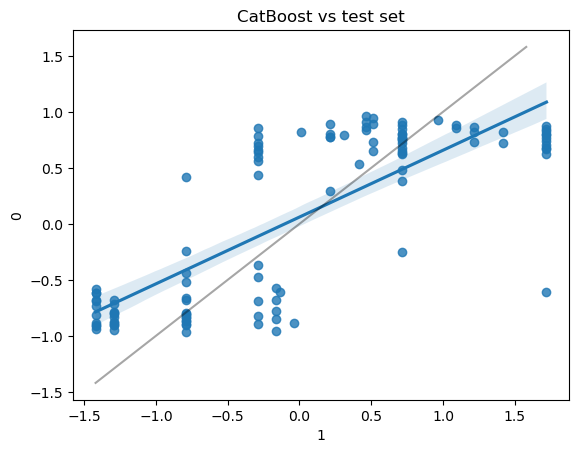

CatBoost vs test set


,0,1,error,mae,mse,r2
0,-0.897484,-0.289563,0.607921,0.497633,0.62186,0.607845


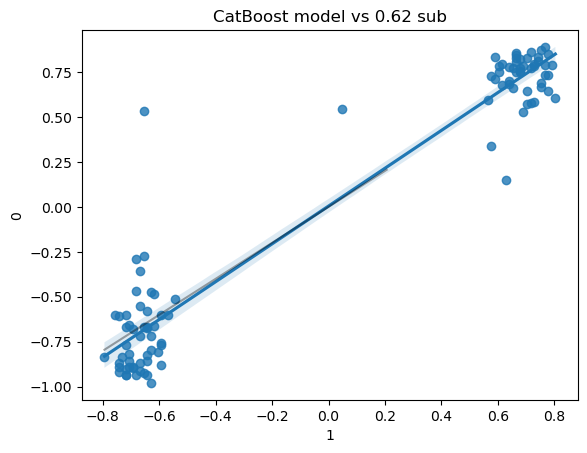

CatBoost model vs 0.62 sub


,0,1,error,mae,mse,r2
0,0.82451,0.665169,-0.159341,0.149771,0.206661,0.907053


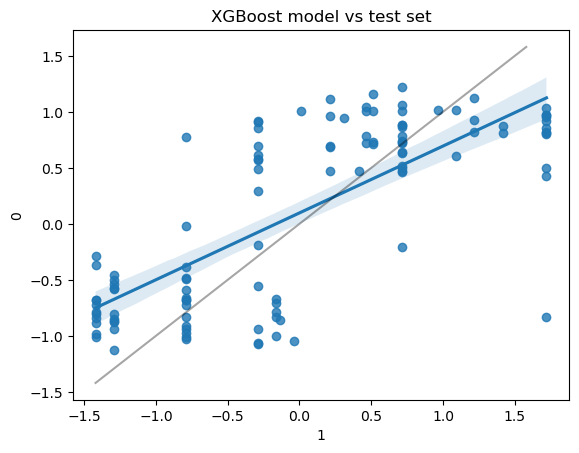

XGBoost model vs test set


,0,1,error,mae,mse,r2
0,-1.074808,-0.289563,0.785245,0.545775,0.670996,0.543424


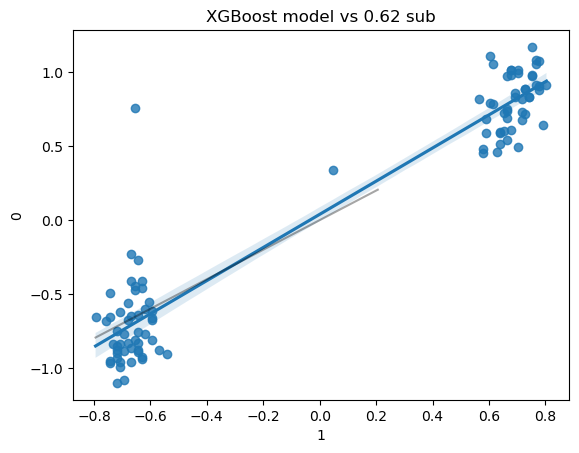

XGBoost model vs 0.62 sub


,0,1,error,mae,mse,r2
0,0.687765,0.665169,-0.022596,0.190477,0.253453,0.860198


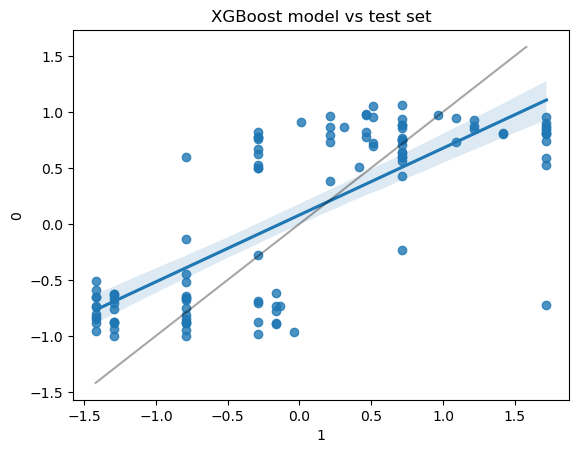

XGBoost model vs test set


,0,1,error,mae,mse,r2
0,-0.986146,-0.289563,0.696583,0.517065,0.639534,0.585237


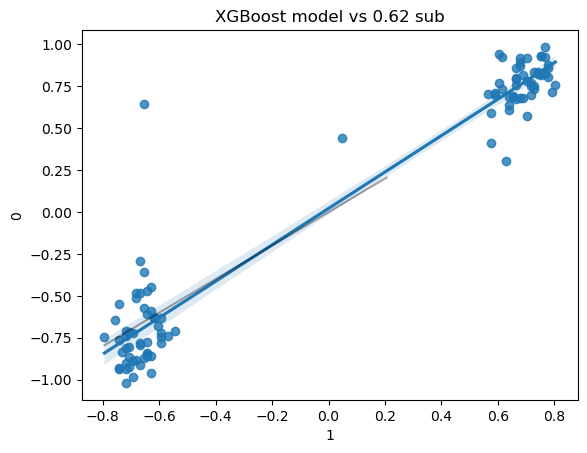

XGBoost model vs 0.62 sub


,0,1,error,mae,mse,r2
0,0.756137,0.665169,-0.090968,0.14643,0.208612,0.90529


In [568]:
# sklearn benchmark
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

sk_model_cat = CatBoostRegressor(n_estimators=1000, learning_rate=10**-1.7, reg_lambda=10**1.4, verbose=100, task_type='GPU', eval_metric='R2')
sk_model_xgb = XGBRegressor(n_estimators=1000, learning_rate=10**-1.7, reg_lambda=10**1.4, tree_method='gpu_hist')
# sk_model_xgb = AdaBoostRegressor(n_estimators=200, learning_rate=10**-0.7)

which = 'encodings'
x_enhanced = GetEncodings(x_scaled, [model, model_tr], which)
xfulltrain_enhanced = GetEncodings(xfulltrain, [model, model_tr], which)
xtest_enhanced = GetEncodings(xtest, [model, model_tr], which)
xsub_enhanced = GetEncodings(xsub, [model, model_tr], which)

sk_models_cat = KFoldTraining(xfulltrain_enhanced, yfulltrain, 5, is_sklearn=True, model_to_train=sk_model_cat)
sk_models_xgb = KFoldTraining(xfulltrain_enhanced, yfulltrain, 5, is_sklearn=True, model_to_train=sk_model_xgb)

EvaluationPlot(sk_models_cat, xtest_enhanced, ytest, 'CatBoost vs test set', is_sklearn=True, plot=True)
EvaluationPlot(sk_models_cat, xsub_enhanced, ytrue, 'CatBoost model vs 0.62 sub', is_sklearn=True, plot=True)

EvaluationPlot(sk_models_xgb, xtest_enhanced , ytest, 'XGBoost model vs test set', is_sklearn=True, plot=True)
EvaluationPlot(sk_models_xgb, xsub_enhanced , ytrue, 'XGBoost model vs 0.62 sub', is_sklearn=True, plot=True)

EvaluationPlot([*sk_models_xgb, *sk_models_cat], xtest_enhanced , ytest, 'XGBoost model vs test set', is_sklearn=True, plot=True)
EvaluationPlot([*sk_models_xgb, *sk_models_cat], xsub_enhanced , ytrue, 'XGBoost model vs 0.62 sub', is_sklearn=True, plot=True)

### NN Models

In [552]:
EvaluationPlot(models, xtest, ytest, 'KFold ConvNet vs Test Set')
EvaluationPlot(models, xsub , ytrue, 'KFold ConvNet vs 0.62 submission')

EvaluationPlot(model, xtest, ytest, '1 ConvNet vs Test Set')
EvaluationPlot(model, xsub , ytrue, '1 ConvNet vs 0.62 submission')

EvaluationPlot(models_tr, xtest, ytest, 'KFold Transformers vs Test Set')
EvaluationPlot(models_tr, xsub , ytrue, 'KFold Transformers vs 0.62 submission')

EvaluationPlot(model_tr, xtest, ytest, '1 Transformer vs Test Set')
EvaluationPlot(model_tr, xsub , ytrue, '1 Transformer vs 0.62 submission')

EvaluationPlot(np.append(model, model_tr), xtest, ytest, 'Mix vs test submission')
EvaluationPlot(np.append(model, model_tr), xsub , ytrue, 'Mix vs 0.62 submission')

KFold ConvNet vs Test Set


,0,1,error,mae,mse,r2
0,-1.066457,-0.289563,0.776893,0.530341,0.660248,0.557934


KFold ConvNet vs 0.62 submission


,0,1,error,mae,mse,r2
0,1.066622,0.665169,-0.401453,0.194966,0.265862,0.846174


1 ConvNet vs Test Set


,0,1,error,mae,mse,r2
0,-1.005306,-0.289563,0.715742,0.521841,0.657599,0.561474


1 ConvNet vs 0.62 submission


,0,1,error,mae,mse,r2
0,1.042342,0.665169,-0.377173,0.191778,0.254418,0.859132


KFold Transformers vs Test Set


,0,1,error,mae,mse,r2
0,-1.015481,-0.289563,0.725918,0.530937,0.660106,0.558125


KFold Transformers vs 0.62 submission


,0,1,error,mae,mse,r2
0,0.912771,0.665169,-0.247602,0.201697,0.271881,0.83913


1 Transformer vs Test Set


,0,1,error,mae,mse,r2
0,-1.005306,-0.289563,0.715742,0.521841,0.657599,0.561474


1 Transformer vs 0.62 submission


,0,1,error,mae,mse,r2
0,1.042342,0.665169,-0.377173,0.191778,0.254418,0.859132


Mix vs test submission


,0,1,error,mae,mse,r2
0,-1.005306,-0.289563,0.715742,0.521841,0.657599,0.561474


Mix vs 0.62 submission


,0,1,error,mae,mse,r2
0,1.042342,0.665169,-0.377173,0.191778,0.254418,0.859132


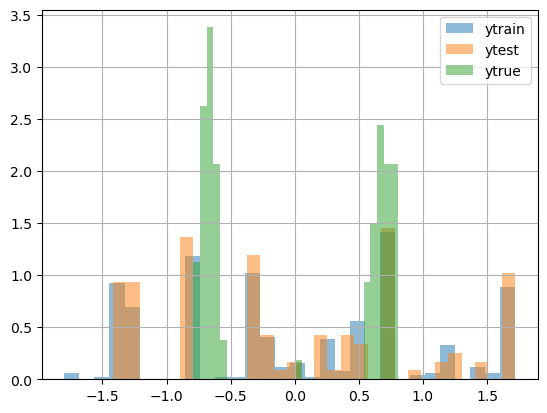

In [553]:
# Distribution of target variables
pd.Series(yfulltrain.squeeze()).hist(density=True, bins=30, label='ytrain', alpha=0.5)
pd.Series(ytest.squeeze()).hist(density=True, bins=30, label='ytest', alpha=0.5)
pd.Series(ytrue).hist(density=True, bins=30, label='ytrue', alpha=0.5)
plt.legend()

## Retrain with full data

In [569]:
# Train KFolds with validation data
models = KFoldTraining(x, y, model='convnet')

  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19    
 best epoch: 29 training loss: 0.2644 best val_R2: 0.576


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19    
 best epoch: 31 training loss: 0.2913 best val_R2: 0.6474


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 29 training loss: 0.2897 best val_R2: 0.6229


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19    
 best epoch: 45 training loss: 0.252 best val_R2: 0.6117


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 41 training loss: 0.2646 best val_R2: 0.6345


In [570]:
# Average validation loss
r2_scores = np.array(models)[:, 1]
models = np.array(models)[:, 0]

print('Average R2 on k-fold:' , r2_scores.mean())

Average R2 on k-fold: 0.6184840825360454


In [572]:
# Train once on all data
model_full = []
for i in np.linspace(30, 50, 5, dtype=int):
    model_full.append(FullDataTraining(x, y, n_epochs=i, model='transformer'))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [573]:
EvaluationPlot(models, xsub, ytrue)
EvaluationPlot(model_full, xsub, ytrue)
EvaluationPlot([*models, *model_full], xsub, ytrue, is_sklearn=False)

,0,1,error,mae,mse,r2
0,0.923868,0.665169,-0.258699,0.177643,0.252982,0.860718


,0,1,error,mae,mse,r2
0,0.842488,0.665169,-0.177318,0.184794,0.25997,0.852917


,0,1,error,mae,mse,r2
0,0.883178,0.665169,-0.218009,0.173903,0.25125,0.862619


In [576]:
# Enhancear con el modelo recién entrenado full
x_enhanced = GetEncodings(x_scaled, [models, model_full], to_return='encodings')
xsub_enhanced = GetEncodings(xsub, [models, model_full], to_return='encodings')

Default metric period is 5 because R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0198516	test: 0.0109599	best: 0.0109599 (0)	total: 198ms	remaining: 3m 17s
100:	learn: 0.6549607	test: 0.4839976	best: 0.4839976 (100)	total: 3.38s	remaining: 30.1s
200:	learn: 0.7258403	test: 0.5271419	best: 0.5271419 (200)	total: 5.2s	remaining: 20.7s
300:	learn: 0.7546720	test: 0.5410129	best: 0.5410129 (300)	total: 7.02s	remaining: 16.3s
400:	learn: 0.7801262	test: 0.5503262	best: 0.5503262 (400)	total: 8.86s	remaining: 13.2s
bestTest = 0.551146514
bestIteration = 411
Shrink model to first 412 iterations.


Default metric period is 5 because R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0194042	test: 0.0163586	best: 0.0163586 (0)	total: 20.8ms	remaining: 20.8s
100:	learn: 0.6399950	test: 0.5961939	best: 0.5961939 (100)	total: 1.94s	remaining: 17.2s
200:	learn: 0.7153247	test: 0.6570180	best: 0.6571532 (199)	total: 3.89s	remaining: 15.5s
300:	learn: 0.7480633	test: 0.6717317	best: 0.6719696 (299)	total: 6.34s	remaining: 14.7s
bestTest = 0.6750301444
bestIteration = 352
Shrink model to first 353 iterations.


Default metric period is 5 because R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0189367	test: 0.0097266	best: 0.0097266 (0)	total: 69.5ms	remaining: 1m 9s
100:	learn: 0.6335204	test: 0.5885644	best: 0.5885644 (100)	total: 2.27s	remaining: 20.2s
200:	learn: 0.7121665	test: 0.6360885	best: 0.6361698 (198)	total: 4.83s	remaining: 19.2s
300:	learn: 0.7493506	test: 0.6450284	best: 0.6453572 (293)	total: 6.92s	remaining: 16.1s
bestTest = 0.6453572403
bestIteration = 293
Shrink model to first 294 iterations.


Default metric period is 5 because R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0172370	test: 0.0180206	best: 0.0180206 (0)	total: 20.2ms	remaining: 20.2s
100:	learn: 0.6365653	test: 0.6527080	best: 0.6527080 (100)	total: 1.81s	remaining: 16.1s
200:	learn: 0.7161738	test: 0.6836264	best: 0.6836359 (199)	total: 3.65s	remaining: 14.5s
bestTest = 0.6843141093
bestIteration = 214
Shrink model to first 215 iterations.


Default metric period is 5 because R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0178591	test: 0.0185929	best: 0.0185929 (0)	total: 18.7ms	remaining: 18.7s
100:	learn: 0.6386612	test: 0.6138000	best: 0.6138000 (100)	total: 1.82s	remaining: 16.2s
200:	learn: 0.7160220	test: 0.6627402	best: 0.6627402 (200)	total: 3.71s	remaining: 14.8s
300:	learn: 0.7518879	test: 0.6703394	best: 0.6703394 (300)	total: 5.56s	remaining: 12.9s
bestTest = 0.6703394441
bestIteration = 300
Shrink model to first 301 iterations.
[18:18:21] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-rmse:1.12062
[1]	validation_0-rmse:1.10955
[2]	validation_0-rmse:1.09879
[3]	validation_0-rmse:1.08841
[4]	validation_0-rmse:1.07861
[5]	validation_0-rmse:1.06854
[6]	validation_0-rmse:1.05783
[7]	validation_0-rmse:1.04738
[8]	validation_0-rmse:1.03775
[9]	validation_0-rmse:1.02795
[10]	validation_0-rmse:1.01914
[11]	validation_0-rmse:1.01010
[12]	validation_0-rmse:1.00135
[13]	validation_0-rmse:0.99251
[14]	validation_0-rmse:0.98440
[15]	validation_0-rms

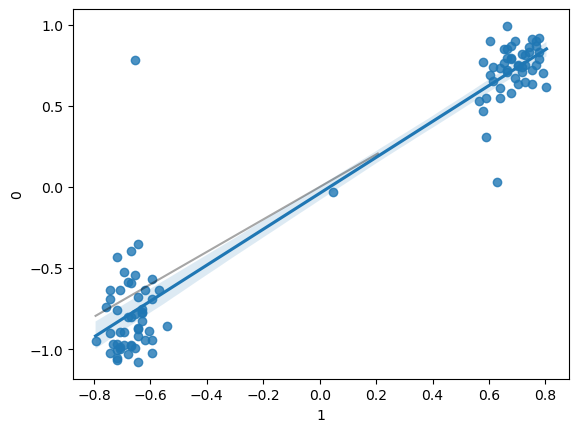

,0,1,error,mae,mse,r2
0,0.99202,0.665169,-0.32685,0.173313,0.24401,0.870422


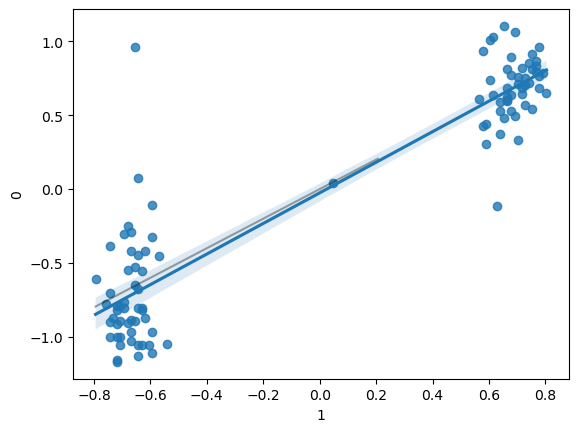

,0,1,error,mae,mse,r2
0,0.683916,0.665169,-0.018747,0.217389,0.304761,0.797868


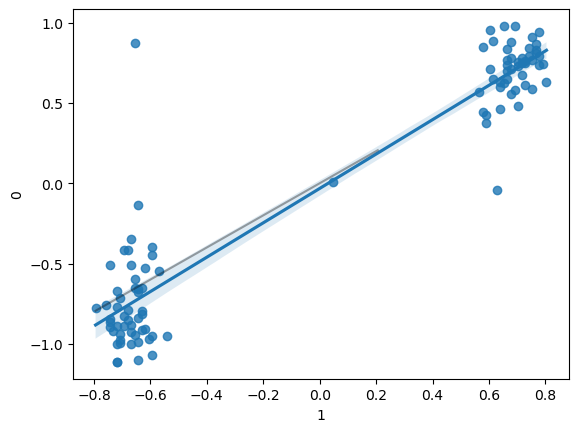

,0,1,error,mae,mse,r2
0,0.837968,0.665169,-0.172799,0.177186,0.260174,0.852686


In [577]:
# sk_model_cat.fit(x_enhanced, scaler_y_sub.transform(y))
# sk_model_xgb.fit(x_enhanced, scaler_y_sub.transform(y))
sk_models_cat = KFoldTraining(x_enhanced, scaler_y_sub.transform(y), 5, True, sk_model_cat)
sk_models_xgb = KFoldTraining(x_enhanced, scaler_y_sub.transform(y), 5, True, sk_model_xgb)
EvaluationPlot(sk_models_cat, xsub_enhanced, ytrue, is_sklearn=True, plot=True)
EvaluationPlot(sk_models_xgb, xsub_enhanced, ytrue, is_sklearn=True, plot=True)
EvaluationPlot([*sk_models_cat, *sk_models_xgb], xsub_enhanced, ytrue, is_sklearn=True, plot=True)

# Make predictions and submit

In [578]:
# sub_preds = np.array(kfold_preds).mean(0)
# # sub_preds = model_full(xsub.to('cuda')).cpu().detach().numpy()
sub_preds = scaler_y_sub.inverse_transform(MakePredictions(sk_models_cat, xsub_enhanced, is_sklearn=True).reshape(-1, 1)).squeeze()

sub_preds

array([7419.78701508, 6019.54557256, 6316.22780309, 7309.00939593,
       5899.87856098, 7240.8637937 , 5996.60419386, 6353.66549178,
       7165.75771538, 7219.41278866, 5948.01327611, 6158.84476429,
       5815.94137456, 6090.99180147, 5881.60303472, 7228.75838322,
       6043.75521232, 5940.35171247, 5849.40931822, 6876.30776333,
       7133.7040244 , 5834.35536274, 7278.31212406, 5838.71024595,
       7093.14850754, 7258.44214068, 7050.94662329, 6286.23942687,
       5774.40106365, 6180.75964478, 5857.35489977, 6080.29169024,
       7290.19769044, 7205.81160093, 7319.09421616, 7177.66807336,
       5781.58071   , 6082.43089334, 6607.91152797, 5996.7266723 ,
       7003.29976765, 5917.84337839, 5935.07846614, 7316.41132733,
       5858.77804213, 6200.58934479, 6124.79880206, 7219.85452159,
       6127.35089761, 6163.88883511, 7213.38496122, 7323.25861551,
       5841.16059297, 7190.16821955, 7253.49472443, 7359.95417941,
       7203.59817048, 7355.0836367 , 5850.6234066 , 5972.59640

In [579]:
submission_df = pd.read_csv('Challenge_2_submission_template.csv')
submission_df['Predicted Rice Yield (kg/ha)'] = sub_preds
submission_df.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha)
0,1,Chau_Phu,10.542192,105.187920,WS,T,10-04-2022,1.40,7419.787015
1,2,Chau_Thanh,10.400189,105.331053,SA,T,15-07-2022,1.32,6019.545573
2,3,Chau_Phu,10.505489,105.203926,SA,D,14-07-2022,1.40,6316.227803
3,4,Chau_Phu,10.523520,105.138274,WS,D,10-04-2022,1.80,7309.009396
4,5,Thoai_Son,10.294660,105.248528,SA,T,20-07-2022,2.20,5899.878561


In [1603]:
submission_df.to_csv('Version 17.csv', index=False)